# Decline curve analysis

We'll look at fitting a decline curve to production data. I'm using information from two sources:

- [SPE Wiki](https://petrowiki.spe.org/Production_forecasting_decline_curve_analysis), wich is content from the Petroelum Engineering Handbook, but which was unfortunately badly converted from the print edition.
- [This tutorial](https://www.cedengineering.com/userfiles/Forecasting%20Oil%20and%20Gas%20Using%20Decline%20Curves.pdf) from John Weaver for CED Engineering.

In particular, we're going to implement the Arps general decline curve equation, and fit its parameter $b$ to some data from an oil field in Norway.

First we'll need some data. Normally you'd use decline curve analysis on data from individual wells, but I'm going to use data from entire fields. This is probably a terrible idea, but maybe we can just think of it as 'average well performance'... notwithstanding that there is probably more than just primary production going on in our examples.

Pandas is very useful for handling time series, so we'll use that to wrangle some data out of the 23,000+ rows in the dataset.

## Use pandas to load CSV

I copied the URL for this CSV from this link:

http://factpages.npd.no/factpages/Default.aspx?culture=nb-no&nav1=field&nav2=TableView|Production|Saleable|Monthly

This file is saved at `https://geocomp.s3.amazonaws.com/data/Norway_field_production_monthly.csv` as well, in case the link breaks.

In [1]:
csv = "https://factpages.npd.no/ReportServer_npdpublic?/FactPages/TableView/field_production_monthly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=165.225.35.29&CultureCode=nb-no"

In [2]:
import pandas as pd

df = pd.read_csv(csv)

In [3]:
df.head()

,prfInformationCarrier,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier
0,16/1-12 (Rolvsnes),2021,8,0.00653,0.0,0.0,0.0,0.00653,0.00291,17196400
1,16/1-12 (Rolvsnes),2021,9,0.01053,0.0,0.0,0.0,0.01053,0.00719,17196400
2,16/1-12 (Rolvsnes),2021,10,0.01238,0.0,0.0,0.0,0.01238,0.00912,17196400
3,16/1-12 (Rolvsnes),2021,11,0.01298,0.0,0.0,0.0,0.01298,0.01186,17196400
4,16/1-12 (Rolvsnes),2021,12,0.00461,0.0,0.0,0.0,0.00461,0.00418,17196400


### Exercise

- How many rows are there in this dataframe?
- How many fields are represented? (Look at the column called `'prfInformationCarrier'`)
- How many years of data are there?
- What is the total production? (Look at the column called `'prfPrdOeNetMillSm3'`)

In [4]:
# YOUR CODE HERE



In [5]:
len(df)

23222

In [6]:
df.describe()

,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdNGLNetMillSm3,prfPrdCondensateNetMillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier
count,23222.000000,23222.000000,23222.000000,23222.000000,23222.000000,23222.000000,23222.000000,23222.000000,2.322200e+04
mean,2007.376066,6.489019,0.200486,0.121110,0.019687,0.005291,0.346574,0.157157,2.884377e+06
std,10.782887,3.469063,0.387877,0.348257,0.043695,0.028137,0.593467,0.384084,6.670064e+06
min,1971.000000,1.000000,-0.037570,-0.103860,-0.020290,-0.008240,-0.037570,-0.002980,4.343700e+04
25%,2000.000000,3.000000,0.007700,0.000000,0.000000,0.000000,0.031530,0.000000,4.356800e+04
50%,2010.000000,6.000000,0.052010,0.014350,0.001810,0.000000,0.131320,0.005140,4.373200e+04
75%,2016.000000,10.000000,0.222357,0.081297,0.018060,0.000000,0.390792,0.124895,1.854729e+06
max,2022.000000,12.000000,3.453530,3.743890,0.458810,0.462690,4.990650,3.651950,3.854224e+07


In [7]:
df.prfInformationCarrier.unique().size

122

In [8]:
df.prfPrdOeNetMillSm3.sum()

8048.14092

### EXERCISE

Make a column called **CondNetMillSm3** that is the sum of the condensate and NGL columns.

Drop the redundant columns.

In [9]:
# YOUR CODE HERE



In [10]:
condensate = ['prfPrdCondensateNetMillSm3', 'prfPrdNGLNetMillSm3']
df['calcCondNetMillSm3'] = df[condensate].sum(axis=1)
df = df.drop(columns=condensate)
df.head()

,prfInformationCarrier,prfYear,prfMonth,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier,calcCondNetMillSm3
0,16/1-12 (Rolvsnes),2021,8,0.00653,0.0,0.00653,0.00291,17196400,0.0
1,16/1-12 (Rolvsnes),2021,9,0.01053,0.0,0.01053,0.00719,17196400,0.0
2,16/1-12 (Rolvsnes),2021,10,0.01238,0.0,0.01238,0.00912,17196400,0.0
3,16/1-12 (Rolvsnes),2021,11,0.01298,0.0,0.01298,0.01186,17196400,0.0
4,16/1-12 (Rolvsnes),2021,12,0.00461,0.0,0.00461,0.00418,17196400,0.0


## Add a datetime

We'd like to give this dataframe a **datetime** index with `pandas` datetimes. To do this easily, we need:

- EITHER columns named like `'year'`, `'month'`, `'day'`
- OR a column with a datetime string like `2019-06-30`.

In this dataframe, we have the former, so let's work with that.

### Exercise

- Make a Series for the date using a pattern like `df['prfYear'].astype(str) + '🐍'` (but don't add it to the dateframe yet).
- Make a datetime column called `'date'` using `pd.to_datetime()`, passing in the Series you just made.
- To turn the new column into an index, give its name to `df.set_index()`.
- Finally, drop all the redundant date-related columns.

You should end up with a new dataframe with the `'date'` column as an index.

In [11]:
# YOUR CODE HERE



In [12]:
date = df['prfYear'].astype(str) + '-' + df['prfMonth'].astype(str) + '-1'

In [13]:
# Build this up.
df['date'] = pd.to_datetime(date)
df = df.set_index('date')
df = df.drop(columns=['prfYear', 'prfMonth'])  # Redundant.
df.head()

,prfInformationCarrier,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3,prfPrdOeNetMillSm3,prfPrdProducedWaterInFieldMillSm3,prfNpdidInformationCarrier,calcCondNetMillSm3
date,,,,,,,
2021-08-01,16/1-12 (Rolvsnes),0.00653,0.0,0.00653,0.00291,17196400,0.0
2021-09-01,16/1-12 (Rolvsnes),0.01053,0.0,0.01053,0.00719,17196400,0.0
2021-10-01,16/1-12 (Rolvsnes),0.01238,0.0,0.01238,0.00912,17196400,0.0
2021-11-01,16/1-12 (Rolvsnes),0.01298,0.0,0.01298,0.01186,17196400,0.0
2021-12-01,16/1-12 (Rolvsnes),0.00461,0.0,0.00461,0.00418,17196400,0.0


## Time series with `pandas`

`pandas` knows all about time series. So we can easily make a time series plot:

<AxesSubplot:xlabel='date'>

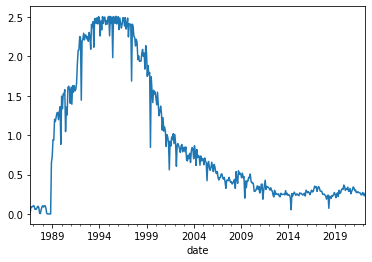

In [14]:
field = df.prfInformationCarrier=='OSEBERG'

df.prfPrdOilNetMillSm3[field].plot()

We can easily stretch it out, or add other lines:

<AxesSubplot:xlabel='date'>

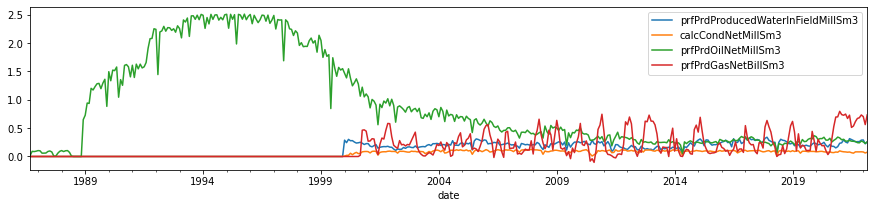

In [15]:
# Put in colour order, knowing matplotlib's default...
features = ['prfPrdProducedWaterInFieldMillSm3',
            'calcCondNetMillSm3',
            'prfPrdOilNetMillSm3',
            'prfPrdGasNetBillSm3',
            ]

df.loc[field, features].plot(figsize=(15, 3))

Let's make a dataframe of only the TROLL field.

In [16]:
oseberg = df.loc[field, features]

Now we can slice using natural dates:

<AxesSubplot:xlabel='date'>

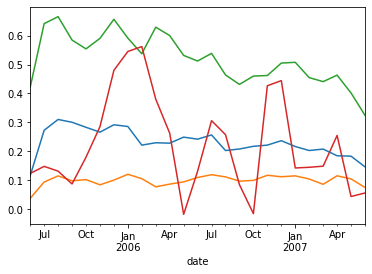

In [17]:
oseberg['Jun 2005':'Jun 2007'].plot(legend=None)

Or resample at some new rate:

In [18]:
oseberg['2000':'2020'].resample('Y').sum()  # <-- You can add .plot() to this too!

,prfPrdProducedWaterInFieldMillSm3,calcCondNetMillSm3,prfPrdOilNetMillSm3,prfPrdGasNetBillSm3
date,,,,
2000-12-31,3.04741,0.62963,15.41082,1.40319
2001-12-31,2.15526,0.95492,10.97032,3.79670
2002-12-31,1.74208,1.01913,10.11254,2.79761
2003-12-31,2.30469,1.02507,9.17511,1.23880
2004-12-31,2.53713,1.18399,8.71377,2.42291
2005-12-31,2.98200,1.16467,7.46677,2.82091
2006-12-31,2.80199,1.25517,6.26178,3.37007
2007-12-31,2.41461,1.30303,5.16358,1.54752
2008-12-31,2.39510,1.17904,5.29253,3.81843


Try to imagine doing that in Excel!

---

## Fit a decline curve

Let's try fitting a decline curve to the Oseberg data.

### EXERCISE

Get the data for 1997 to 2004, when the oil production declined on a curve, more or less. Multiply it by 1,000,000 so that it's in units of m<sup>3</sup>.

Make a time series for the data using `np.arange()`. Make sure it's the same size as the production dataset (that is, the same length).

In [19]:
# YOUR CODE HERE.



<AxesSubplot:xlabel='date'>

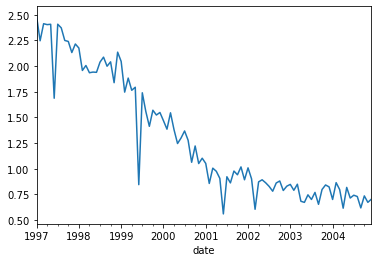

In [20]:
oseberg.loc['1997':'2004'].prfPrdOilNetMillSm3.plot()

In [21]:
import numpy as np

# Make flow rate and time (in months)
q = oseberg.loc['1997':'2004'].prfPrdOilNetMillSm3.values * 1e6
t = np.arange(q.size)

### EXERCISE

Now we need to implement the general **hyperbolic decline** curve using [Arp's equation](https://petrowiki.spe.org/Production_forecasting_decline_curve_analysis):

$$ Q(t) = \frac{Q_i}{(1 + b D_i t)^{1 / b}} $$

where $Q_i$ is the inital rate, $t$ is cumulative time and $D_i$ is the initial decline rate, a constant. In general, $0 \le b \le 1$, and although it can be as high as 2.0 in shale reservoirs it is usually $0 \le b \le 0.5$ for conventional reservoirs. There are two special cases of this general function:

- **Exponential decline** where $b = 0$, so $ Q = Q_i \mathrm{e}^{-dt} $.
- **Harmonic decline** where $b = 1$, so $ Q = Q_i / (1 + d_i t) $.

**Implement the equation and make a plot showing how a production rate of 10,000 would fall over 10,000 days. Assume an initial decline rate of 0.1%.**

In [22]:
# YOUR CODE HERE



In [23]:
import numpy as np

def flow_rate(t, b, Qi, Di):
    """Arps' equation.
    
    Args:
        t (array-like): The time basis. Can be a scalar.
        b (float): The so-called 'b-factor'.
        Qi (float): The initial production rate.
        Di (float): The initial fractional depletion rate.
        
    Returns:
        array-like: The rate at each time in t. If t is scalar,
            this will be a scalar value.
    """
    b += 1e-12  # Deal with potential div0 error.
    return Qi / (1 + b * Di * t)**(1 / b)

T = np.arange(10_000)
Q = flow_rate(T, Qi=10_000, Di=0.001, b=0.25)

Q

array([10000.        ,  9990.00624688,  9980.02497502, ...,
          66.69605013,    66.67699343,    66.65794354])

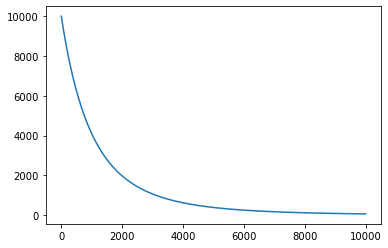

In [24]:
import matplotlib.pyplot as plt

plt.plot(T, Q)

## Optimization

SciPy has an optimization module, `scipy.optimize`. In there is a convenient fitting function called [`curve_fit()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). The function is not too difficult to use when you have some data `X` and `y`, and a very simple function `func` with one parameter `w` to optimize:

```
def func(x, w):
    y = np.exp(w * x)
    return y
    
popt, pcov = curve_fit(func, X, y)
```

Suppose we have other arguments, say `a`, that we do **not** want to fit (hyperparameters):

```
def func2(x, w, a):
    y = a + np.exp(w * x)
    return y
```

Now we have to wrap `func` with another function that sets those other arguments. This is conceptually a bit tricky but Python's `functools` library provides a tool to help do it:

```
func = partial(func2, a=10)
```

The only catch is that the order of arguments in `func2` is not changed, so if we need the returned function to have a call signature like `func(x, w)` then `a` must come after `w` in the original function's (`func2`) call signature.

Anyway, now we can call `func` and ignore the argument `a`.

In [25]:
# NB Sometimes it's neater to wrap with another function that accepts
# the hyperparameters at call time. Here's how you can do this:
def func(Qi, Di): # What we will call, setting Qi and Di.
    def f(t, b):  # Required call signature for `curve_fit`.
        return flow_rate(t=t, Qi=Qi, Di=Di, b=b)
    return f

f = func(Qi=1000, Di=0.01)

# Now you can call f with the desired arguments:
f(t=100, b=0.5)

# It amounts to the same thing as `partial` but it's a bit neater in the
# calling code and is much harder to explain to a beginner. Also, this
# recipe allows us to define `flow_rate`'s arguments in any order.

444.4444444445726

In [26]:
def effective_decline(Q):
    return (Q[0] - Q[1]) / Q[0] # Wiki has Q[1] in the denominator, surely that's wrong??

def hyperbolic_decline(Q):
    """aka Nominal decline, accroding to SPE Wiki."""
    return -np.log(1 - effective_decline(Q))

In [27]:
from functools import partial
from scipy.optimize import curve_fit

Qi = q[0]
Di = effective_decline(q)  # Initial effective fractional decline.

func = partial(flow_rate, Qi=Qi, Di=Di)

popt, pcov = curve_fit(func, t, q, bounds=(0, 1.0))
popt

array([1.])

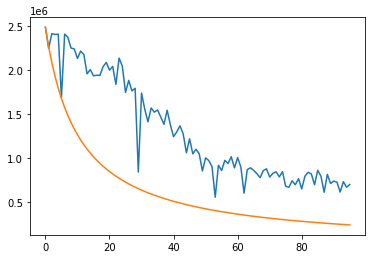

In [28]:
q_pred = flow_rate(t, b=popt, Qi=Qi, Di=Di)

plt.plot(t, q)
plt.plot(t, q_pred)

It seems the initial production rate is too high.

### Would it make a difference to smooth the input?

The production curve is spiky, probably reflecting regular maintenance shutdowns. Does it make a difference if we remove those, e.g. with a median filter?

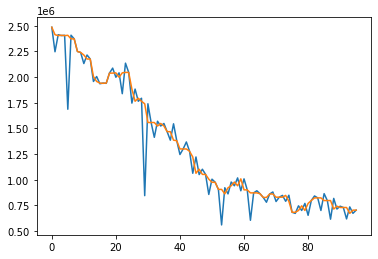

In [29]:
# Try a median filter to get rid of the shutdown months.
from scipy.ndimage import median_filter

q_smooth = median_filter(q, size=3)

plt.plot(t, q)
plt.plot(t, q_smooth)

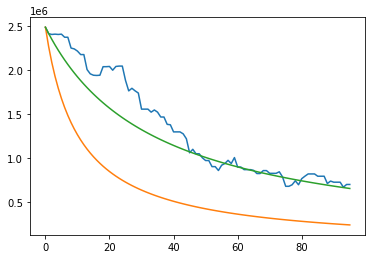

In [30]:
Qi = q_smooth[0]
Di = effective_decline(q_smooth)

func = partial(flow_rate, Qi=Qi, Di=Di)

popt, pcov = curve_fit(func, t, q_smooth, bounds=(0, 1.0))

q_pred_smooth = flow_rate(t, b=popt, Qi=Qi, Di=Di)

plt.plot(t, q_smooth)
plt.plot(t, q_pred)
plt.plot(t, q_pred_smooth)

In [31]:
popt

array([1.])

### EXERCISE

Recover the oil production data for the TROLL field.

Use OSEBERG's decline model to predict TROLL's production from July 2003 to December 2012.

How well does it match? For example, what's the relative error in total production over the period?

In [41]:
# YOUR CODE HERE



<AxesSubplot:xlabel='date'>

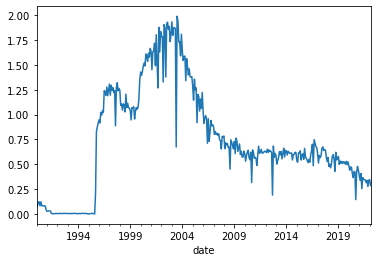

In [42]:
troll = df.loc[df['prfInformationCarrier']=='TROLL', features]

troll.prfPrdOilNetMillSm3.plot()

<AxesSubplot:xlabel='date'>

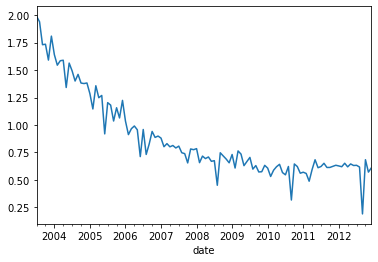

In [43]:
troll.loc['Jul 2003':'Dec 2012'].prfPrdOilNetMillSm3.plot()

In [35]:
q_troll = troll.loc['Jul 2003':'Dec 2012'].prfPrdOilNetMillSm3.values * 1e6
t_troll = np.arange(q_troll.size)

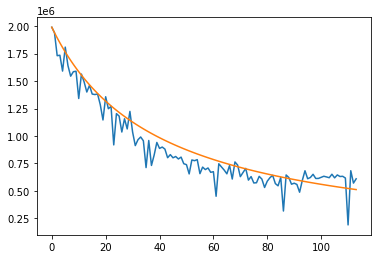

In [36]:
Qi_troll = q_troll[0]
Di_troll = hyperbolic_decline(q_troll)

q_pred = flow_rate(t_troll, b=popt, Qi=Qi_troll, Di=Di_troll)

plt.plot(t_troll, q_troll)
plt.plot(t_troll, q_pred)

Not too bad! How does the cumulative production compare?

In [37]:
def error(y_true, y_pred):
     return 100 * (y_pred.sum() - y_true.sum()) / y_true.sum()

err = error(q_troll, q_pred)

print(f"With b = {popt[0]:0.2f}, we get a relative error of {err:.1f}%") 

With b = 1.00, we get a relative error of 6.9%


Using Oseberg's value for `b` I got an overestimate of 6.9%.

What if we'd known the optimal parameter? Try refitting the model to Troll's data and seeing the difference:

In [ ]:
# YOUR CODE HERE



In [40]:
# Refit model on TROLL data.
func = partial(flow_rate, Qi=Qi_troll, Di=Di_troll)

popt, pcov = curve_fit(func, t_troll, q_troll, bounds=(0, 1.0))

q_pred = flow_rate(t_troll, b=popt, Qi=Qi_troll, Di=Di_troll)

err = error(q_troll, q_pred)
print(f"With b = {popt[0]:0.2f}, we get a relative error of {err:.1f}%") 

With b = 0.82, we get a relative error of 2.4%


----

&copy; 2022 Agile Scientific, licensed CC-BY